In [86]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
from scipy.stats import kstest
from scipy.stats import anderson
import copy

In [2]:
# Read train and validation data
train = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_t_var_sel.csv")
val = pd.read_csv("/Users/jinwoolee/Downloads/Bank Project/insurance_v_var_sel.csv")

In [3]:
# First ten observations of train
train.head(10)

# We have a dataset derived from previous analysis, which allowed us to indentify 
# potential predictor variables related to the purchase of the annuity product

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,CCPURC,SDB,INCOME,LORES,HMVAL,AGE,CRSCORE,INAREA,INS,BRANCH
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1.0,0,4.0,7.0,87.0,51.0,674.0,1,0,B2
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,0.0,0,30.0,8.5,97.0,60.0,640.0,1,1,B3
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,0.0,0,19.0,3.0,107.0,55.0,662.0,1,1,B7
3,0.8,1,190.03,3,880.25,1,0,1,5.65,NaN,...,NaN,1,20.0,4.0,107.0,40.0,642.0,1,0,B14
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,NaN,...,NaN,0,24.0,8.5,95.0,54.0,732.0,1,0,B15
5,5.3,0,0.00,0,0.00,0,0,0,0.00,NaN,...,NaN,0,8.0,12.5,76.0,61.0,688.0,1,1,B19
6,9.0,1,1072.55,1,590.25,0,0,1,5.78,NaN,...,NaN,0,45.0,8.5,111.0,54.0,635.0,1,1,B15
7,4.0,0,0.00,0,0.00,0,0,0,0.00,NaN,...,NaN,0,35.0,3.5,99.0,46.0,642.0,1,1,B14
8,NaN,1,998.25,2,1471.81,4,1,0,0.00,0.0,...,0.0,0,88.0,8.0,129.0,22.0,626.0,1,1,B1
9,1.5,0,0.00,0,0.00,0,0,0,0.00,NaN,...,NaN,0,31.0,4.0,97.0,53.0,693.0,0,0,B18


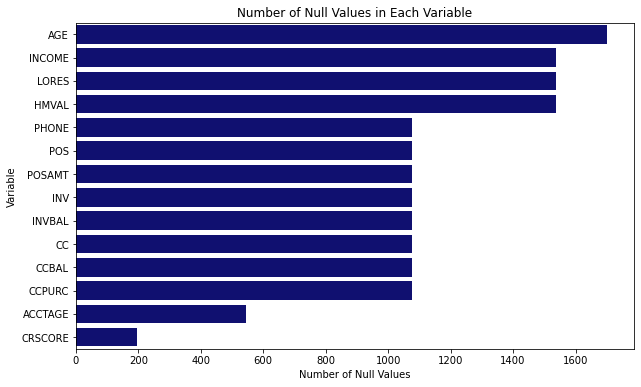

,Variable,Null_Count
12,AGE,1702
9,INCOME,1537
10,LORES,1537
11,HMVAL,1537
1,PHONE,1075
2,POS,1075
3,POSAMT,1075
4,INV,1075
5,INVBAL,1075
6,CC,1075


In [4]:
#Find null values
var_with_null = {'Variable': [], 'Null_Count': []}

# Check all variables
for column in train.columns:
    null_count = train[column].isnull().sum()
    if null_count > 0:
        var_with_null['Variable'].append(column)
        var_with_null['Null_Count'].append(null_count)

var_with_null = pd.DataFrame(var_with_null).sort_values(by = 'Null_Count', ascending = False)

# Plot of the number of null values
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Null_Count', y = 'Variable', data = var_with_null, color = 'navy')
plt.title('Number of Null Values in Each Variable')
plt.xlabel('Number of Null Values')
plt.ylabel('Variable')
plt.show()

var_with_null

In [5]:
# Create a binary flag variable that indicates missing values
for var in var_with_null['Variable']:
    train[f'{var}_FLAG'] = train[var].notna().astype(int)

train

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,PHONE_FLAG,POS_FLAG,POSAMT_FLAG,INV_FLAG,INVBAL_FLAG,CC_FLAG,CCBAL_FLAG,CCPURC_FLAG,ACCTAGE_FLAG,CRSCORE_FLAG
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,1,1,1,1,1,1,1,1,1,1
3,0.8,1,190.03,3,880.25,1,0,1,5.65,NaN,...,0,0,0,0,0,0,0,0,1,1
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,NaN,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,10.8,1,2262.87,2,4761.00,7,0,1,7.75,2.0,...,1,1,1,1,1,1,1,1,1,1
8491,6.5,1,3683.22,2,3271.05,13,1,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
8492,8.6,1,46593.63,3,55203.58,9,1,0,0.00,0.0,...,1,1,1,1,1,1,1,1,1,1
8493,NaN,0,0.00,0,0.00,0,0,0,0.00,0.0,...,1,1,1,1,1,1,1,1,0,1


In [6]:
# Identify classes of variables: categorical or continuous
cat_var = []
cont_var = []

for column in train.columns:
    if column == 'BRANCH':
        cat_var.append(column)
    elif train[column].nunique() <= 10:
        cat_var.append(column)
    else:
        cont_var.append(column)

In [7]:
# Use median and mode imputation for continuous and categorical variables, respectively
for var in var_with_null['Variable']:
    if var in cat_var:
        train[var] = train[var].fillna(train[var].mode()[0])
    else:
        train[var] = train[var].fillna(train[var].median())

In [8]:
# Divide predictor variables and target variable into individual dataframes
X_train = train.drop(['INS'], axis = 1)
Y_train = train['INS']

# Create dummy variables for branch (branch is a categorical variable with string values)
branch_dummy = pd.get_dummies((train['BRANCH']), drop_first=True)

# Replace branch with the dummy variables created
X_train = X_train.drop(['BRANCH'], axis = 1)
X_train = pd.concat([X_train, branch_dummy], axis = 1)

## Data Standardization

* If data follows a **normal** distribution, we can standardize it by using sklearn's StandardScaler
    * Visualize the histogram
    * **Shapiro-Wilk test** for small to moderate sized data
    * **Anderson-Darling test** for data with kurtosis
    * **Kolmogorov-Smirnov Test**
    * These test all share the following:
        * $H_{0}$: Normally distributed
        * $H_{A}$: Not normally distributed
* Otherwise (i.e., **skewed** or **binary**), apply midrange standardization

In [ ]:
# Histograms of predictor variables
for column in X_train.columns:
    plt.figure()  # Create a new figure for each histogram
    X_train[column].plot.hist(title=column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# LORES, AGE, and CRSCORE may follow a normal distribution according to their histograms but need to conduct further test to confirm

In [10]:
# Run the Anderson-Darling on LORES, AGE, and CRSCORE
# If the returned statistic is larger than these critical values then for the corresponding significance level,
# the null hypothesis that the data follows a normal distribution can be rejected. 
# Also run a KS Test on LORES, AGE, and CRSCORE
print('LORES normality test results:')
print(kstest(X_train['LORES'], 'norm'))
print(anderson(X_train['LORES']), '\n')
print('AGE normality test results:')
print(kstest(X_train['AGE'], 'norm'))
print(anderson(X_train['AGE']), '\n')
print('CRSCORE normality test results:')
print(kstest(X_train['CRSCORE'], 'norm'))
print(anderson(X_train['CRSCORE']))

# Given these results, for all variables in question, we have sufficient evidence to reject the null hypothesis
# Hence, we need to apply midrange standardization for all variables

LORES normality test results:
KstestResult(statistic=0.9802529597477966, pvalue=0.0)
AndersonResult(statistic=96.7676675691182, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])) 

AGE normality test results:
KstestResult(statistic=1.0, pvalue=0.0)
AndersonResult(statistic=78.57634386639256, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])) 

CRSCORE normality test results:
KstestResult(statistic=1.0, pvalue=0.0)
AndersonResult(statistic=1.3168096204572066, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [74]:
# Apply midrange standardization on all variables
X_train_scaled = X_train.copy()

for predictor in X_train_scaled:
    max = X_train_scaled[predictor].max()
    min = X_train_scaled[predictor].min()
    X_train_scaled[predictor] = (X_train_scaled[predictor] - ((max - min)/2)) / ((max - min)/2)

X_train_scaled

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,B18,B19,B2,B3,B4,B5,B6,B7,B8,B9
0,-0.975000,1.0,-0.984725,-0.928571,-0.998157,-0.959184,1.0,-1.0,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-0.853571,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.560714,1.0,-0.991775,-0.642857,-0.971897,-0.469388,1.0,-1.0,-1.000000,-0.733333,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
3,-0.971429,1.0,-0.998539,-0.785714,-0.996369,-0.959184,-1.0,1.0,-0.964808,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-0.942857,1.0,-0.998023,-0.642857,-0.985942,-0.428571,-1.0,1.0,-0.624727,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,-0.614286,1.0,-0.982602,-0.857143,-0.980363,-0.714286,-1.0,1.0,-0.951728,-0.733333,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8491,-0.767857,1.0,-0.971682,-0.857143,-0.986508,-0.469388,1.0,-1.0,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8492,-0.692857,1.0,-0.641772,-0.785714,-0.772306,-0.632653,1.0,-1.0,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8493,-0.857143,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Support Vector Machine

* **Feature Importance**: measures the average decrease in purity in the nodes of the tree (essentially measuring how much each variable improves the purity of the model when it is added)

* **Hyperparameters examples**:

    * **C** (Regularization parameter): C controls the trade-off between maximizing the margin and minimizing the classification error. A smaller C leads to a larger margin but may allow more misclassifications on the training data, while a larger C emphasizes classifying the training data correctly but may result in a narrower margin and potential overfitting.

    * Kernel choice: SVMs can use different kernel functions to map input data into higher-dimensional space, allowing for nonlinear decision boundaries. Common choices:

        * **Linear** kernel: Suitable for linearly separable data or large datasets.
        * **Polynomial** kernel: Allows modeling of non-linear decision boundaries. Parameters to tune include degree and coefficient of the polynomial.
        * Radial Basis Function (**RBF**) kernel: Suitable for non-linearly separable data and widely used due to its flexibility. Parameters to tune include gamma.
        
    * **Gamma** for RBF kernel: Gamma determines the influence of each training example. A small gamma means a large radius for the Gaussian kernel, leading to a smoother decision 
    boundary, while a large gamma means a smaller radius, making the decision boundary more tightly around data points. The choice of gamma significantly impacts the model's complexity and generalization ability.

    * **Degree** for Polynomial kernel: The degree parameter specifies the degree of the polynomial kernel function. Higher degrees can capture more complex relationships in the data but may also lead to overfitting.

    * Class weights (**class_weight**): SVMs can be sensitive to class imbalance. The class_weight parameter allows you to assign different weights to different classes to balance their contribution to the model's training.

    * Kernel coefficient (**coef0**): This parameter affects the influence of higher-order terms in the polynomial kernel function. It is used in polynomial and sigmoid kernels.

    * Tolerance for stopping criterion (**tol**): The tolerance parameter determines the stopping criterion for the optimization process. Smaller values lead to longer training times but potentially better accuracy.
    
    * Probability estimation (**probability**): Setting probability=True enables probability estimates using Platt scaling or the more efficient method of isotonic regression. This can be useful if you need probability estimates rather than just class predictions.

In [53]:
# Build a Support Vector Machine model
svm = SVC(random_state = 123, probability = True)
svm.fit(X_train_scaled, Y_train)

# Compute and add a column of predicted probabilities on the training dataset
INS_hat = svm.predict_proba(X_train_scaled)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})
X_train_scaled['INS_hat'] = INS_hat

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_train, X_train_scaled['INS_hat'])

# Print the training AUC
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))
X_train_scaled = X_train_scaled.drop("INS_hat", axis = 1)

Model's AUC is 0.76


In [54]:
# First round of tuning hyperparameters
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 1, 0.1],
    'kernel': ['rbf', 'linear']
}

svm = SVC()

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, cv = 5, scoring = 'roc_auc', verbose = 2)

grid_search.fit(X_train_scaled, Y_train)

grid_search.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   3.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   3.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   3.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   3.1s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.1s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   4.2s
[CV] END ...........................C=1, gamma=1

{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}

In [55]:
# After first round of tuning
svm = SVC(C = 100, gamma = 'scale', kernel = 'linear', random_state = 123, probability = True)
svm.fit(X_train_scaled, Y_train)

# Compute and add a column of predicted probabilities on the training dataset
INS_hat = svm.predict_proba(X_train_scaled)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})
X_train_scaled['INS_hat'] = INS_hat

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_train, X_train_scaled['INS_hat'])

# Print the training AUC
base_auc = auc(fpr, tpr)
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))
X_train_scaled = X_train_scaled.drop("INS_hat", axis = 1)

Model's AUC is 0.78


In [56]:
# Initialize an empty dataframe to store feature importance
importances = pd.DataFrame(index =  X_train_scaled.columns)

# Iterate through each feature and computed the the difference between permuted and baseline AUC
for predictor in X_train_scaled.columns:

    # Permutate each predictor variable
    predictor_permuted = copy.deepcopy(X_train_scaled)
    predictor_permuted[predictor] = np.random.permutation(predictor_permuted[predictor])

    # Compute and add a column of predicted probabilities on the training dataset
    INS_hat = svm.predict_proba(predictor_permuted)[:,1]
    INS_hat = pd.DataFrame({'INS_hat': INS_hat})
    predictor_permuted['INS_hat'] = INS_hat

    # Establish the false positive rate, true positive rate, and the optimal cutoff
    fpr, tpr, thresholds = roc_curve(Y_train, predictor_permuted['INS_hat'])
    auc_after_permutation = auc(fpr, tpr)

    # Difference between base AUC and AUC after permutation
    importances.loc[predictor, 'Importance'] = base_auc - auc_after_permutation
    predictor_permuted = predictor_permuted.drop("INS_hat", axis = 1)

# Normalize importances
importances['Importance'] = importances['Importance']/importances['Importance'].sum()
importances = importances.sort_values(by='Importance', ascending=False)
importances

,Importance
MM,0.287360
SAVBAL,0.186001
DDABAL,0.110733
CD,0.077562
MMBAL,0.064578
...,...
HMVAL,-0.000410
B6,-0.000629
POSAMT_FLAG,-0.000695
CC_FLAG,-0.001197


In [84]:
# Remove the variables with negative importance
neg_importance = importances[importances['Importance'] > 0]

X_train_scaled_reduced = copy.deepcopy(X_train_scaled)
X_train_scaled_reduced = X_train_scaled[neg_importance.index]

In [85]:
# See how the model performs with reduced number of features
svm = SVC(C = 100, gamma = 'scale', kernel = 'linear', random_state = 123, probability = True)
svm.fit(X_train_scaled_reduced, Y_train)

# Compute and add a column of predicted probabilities on the training dataset
INS_hat = svm.predict_proba(X_train_scaled_reduced)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})
X_train_scaled_reduced['INS_hat'] = INS_hat

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_train, X_train_scaled_reduced['INS_hat'])

# Print the training AUC
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

# The model with reduced number of predictors does not have a higher AUC
# We move forward with the dataset with all variables

Model's AUC is 0.78


In [87]:
# Second round of tuning hyperparameters
param_grid = {
    'C': [75, 100, 200],
    'gamma': ['scale', 1, 0.01],
    'kernel': ['rbf', 'linear']
}

svm = SVC()

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid, cv = 5, scoring = 'roc_auc', verbose = 2)

grid_search.fit(X_train_scaled, Y_train)

grid_search.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=75, gamma=scale, kernel=rbf; total time=   4.0s
[CV] END ......................C=75, gamma=scale, kernel=rbf; total time=   3.8s
[CV] END ......................C=75, gamma=scale, kernel=rbf; total time=   3.8s
[CV] END ......................C=75, gamma=scale, kernel=rbf; total time=   3.7s
[CV] END ......................C=75, gamma=scale, kernel=rbf; total time=   3.8s
[CV] END ...................C=75, gamma=scale, kernel=linear; total time=  23.4s
[CV] END ...................C=75, gamma=scale, kernel=linear; total time=  19.9s
[CV] END ...................C=75, gamma=scale, kernel=linear; total time=  20.6s
[CV] END ...................C=75, gamma=scale, kernel=linear; total time=  20.1s
[CV] END ...................C=75, gamma=scale, kernel=linear; total time=  20.2s
[CV] END ..........................C=75, gamma=1, kernel=rbf; total time=   4.8s
[CV] END ..........................C=75, gamma=1

{'C': 200, 'gamma': 'scale', 'kernel': 'linear'}

In [88]:
# After second round of tuning
svm = SVC(C = 200, gamma = 'scale', kernel = 'linear', random_state = 123, probability = True)
svm.fit(X_train_scaled, Y_train)

# Compute and add a column of predicted probabilities on the training dataset
INS_hat = svm.predict_proba(X_train_scaled)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})
X_train_scaled['INS_hat'] = INS_hat

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_train, X_train_scaled['INS_hat'])

# Print the training AUC
base_auc = auc(fpr, tpr)
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))
X_train_scaled = X_train_scaled.drop("INS_hat", axis = 1)

# Second round of tuning did not improve AUC and adds a layer of unnecessary complication
# Thus, we move forward with the previous model

Model's AUC is 0.78


In [89]:
# Final model
svm = SVC(C = 100, gamma = 'scale', kernel = 'linear', random_state = 123, probability = True)
svm.fit(X_train_scaled, Y_train)

SVC(C=100, kernel='linear', probability=True, random_state=123)

In [94]:
# Predicted probabilities on the training dataset
INS_hat = svm.predict_proba(X_train_scaled)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})

X_train_scaled['INS_hat'] = INS_hat

,TPR,FPR,Cut-off,Youden
1857,0.778958,0.322754,0.270388,0.456204
1861,0.779986,0.323830,0.270174,0.456156
1839,0.774846,0.318809,0.271891,0.456036
1841,0.775188,0.319168,0.271721,0.456020
1859,0.779301,0.323471,0.270314,0.455829


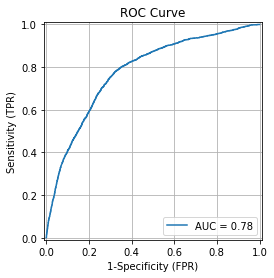

Optimal cutoff is 0.27
Youden's Index (K-S Statistic) is 0.46
Model's AUC is 0.78


In [96]:
# Visualize the ROC curve

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_train, X_train_scaled['INS_hat'])

# Compute Youden's Index
data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)
youden = youden.sort_values(by = ['Youden'], ascending = False)
display(youden.head(5))

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc(fpr, tpr))
roc_display.plot()

plt.title('ROC Curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.grid(True)

plt.show()

# Print the optimal cutoff, Youden's index, and AUC
print("Optimal cutoff is", round(youden.loc[1857, 'Cut-off'], 2))
print("Youden's Index (K-S Statistic) is", round(youden.loc[1857, 'Youden'], 2))
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

# Our lowest AUC on the training dataset so far

## Validation Dataset
* Apply all changes made to the training dataset onto the validation dataset
* Get the predicted probabilities of all observations and compute the AUC

In [90]:
# Create a binary flag variable that indicates missing values
for var in var_with_null['Variable']:
    val[f'{var}_FLAG'] = val[var].notna().astype(int)

# Use median and mode imputation for continuous and categorical variables, respectively
for var in var_with_null['Variable']:
    if var in cat_var:
        val[var] = val[var].fillna(train[var].mode()[0])
    else:
        val[var] = val[var].fillna(train[var].median())

# Divide predictor variables and target variable into individual dataframes
X_val = val.drop(['INS'], axis = 1)
Y_val = val['INS']

# Create dummy variables for branch (branch is a categorical variable with string values)
branch_dummy = pd.get_dummies((val['BRANCH']), drop_first=True)

# Replace branch with the dummy variables created
X_val = X_val.drop(['BRANCH'], axis = 1)
X_val = pd.concat([X_val, branch_dummy], axis = 1)

# Apply midrange standardization on all variables
X_val_scaled = X_val.copy()

for predictor in X_val_scaled:
    max = X_val_scaled[predictor].max()
    min = X_val_scaled[predictor].min()
    X_val_scaled[predictor] = (X_val_scaled[predictor] - ((max - min)/2)) / ((max - min)/2)

X_val_scaled

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,B18,B19,B2,B3,B4,B5,B6,B7,B8,B9
0,-0.960352,1.0,-0.990533,-0.764706,-0.974538,-0.794872,-1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
1,-0.986784,1.0,-0.883618,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.801762,1.0,-0.965986,-0.529412,-0.892647,-0.692308,-1.0,-1.0,-1.000000,-0.8,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-0.876652,1.0,-0.978729,-0.647059,-0.946841,-0.794872,-1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-0.726872,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,-0.925110,1.0,-0.983848,-0.294118,-0.883478,-0.230769,1.0,1.0,-0.767571,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
2120,-0.938326,1.0,-0.998302,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2121,-0.951542,1.0,-0.852082,-0.647059,-0.932978,-0.948718,1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2122,-0.876652,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0


In [91]:
# Compute and add a column of predicted probabilities on the validation dataset
INS_hat = svm.predict_proba(X_val_scaled)[:,1]
INS_hat = pd.DataFrame({'INS_hat': INS_hat})
X_val_scaled['INS_hat'] = INS_hat

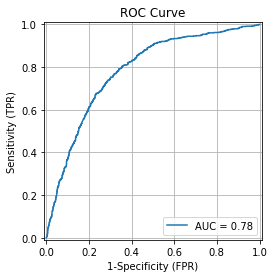

Model's AUC is 0.78


In [92]:
# Visualize the ROC curve

# Establish the false positive rate, true positive rate, and the optimal cutoff
fpr, tpr, thresholds = roc_curve(Y_val, X_val_scaled['INS_hat'])

# Plot ROC curve
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc(fpr, tpr))
roc_display.plot()

plt.title('ROC Curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.grid(True)

plt.show()

# Print the AUC
print("Model's AUC is", str(round(auc(fpr, tpr), 2)))

# Performed relatively similarly compared to the training dataset which also had an AUC of 0.78
# However, the SVM had the same AUC as the logistic regression model at 0.78

In [97]:
# Confusion matrix where we make predictions from predicted probabilities based on the optimal cut-off
X_val_scaled['INS_pred'] = X_val_scaled['INS_hat'].map(lambda x: 1 if x > (youden.loc[1857, 'Cut-off']) else 0)
pd.crosstab(Y_val, X_val_scaled['INS_pred'])

# Although the AUC was the lowest, notice that out of all the models, this model did the best when it came to capturing the actual purchases (due to a lower cut-off)
# High sensitivity would be EXTREMELY essential in cases where even capturing marginally more purchases would tremendously increase profit

INS_pred,0,1
INS,,
0,624,758
1,59,683


In [99]:
svm_results_train = X_train_scaled[['INS_hat']]
svm_results_train.to_csv('Train_Results_SVM.csv')

svm_results_val = X_val_scaled[['INS_hat']]
svm_results_val.to_csv('Val_Results_SVM.csv')